# Functions definition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# GRAPH GENERATION
def create_strongly_connected_directed_graph(N, extra_edges=5):
    G = nx.DiGraph()
    # Add nodes
    G.add_nodes_from(range(N))
    # Create a directed ring
    for i in range(N):
        G.add_edge(i, (i + 1) % N)
    # Randomly add more edges to ensure strong connectivity
    while not nx.is_strongly_connected(G):
        u, v = np.random.randint(0, N), np.random.randint(0, N)
        if u != v:
            G.add_edge(u, v)
    # Add extra edges
    for _ in range(extra_edges):
        u, v = np.random.randint(0, N), np.random.randint(0, N)
        if u != v:
            G.add_edge(u, v)
    A = nx.adjacency_matrix(G).toarray()
    return A
    
# PROTOCOLS 
def standard_protocol(L, x, kappa, g):
    N = L.shape[0]
    I = np.eye(N)
    u = -kappa * L @ x
    return u
    
def centralized_protocol(L, x, kappa, g):
    N = L.shape[0]
    I = np.eye(N)
    W = np.linalg.inv(I + kappa * g * L)
    u = -kappa * W @ L @ x
    return u

def distributed_protocol(L, A, x, kappa, g, gamma):
    N = L.shape[0]
    u = np.zeros(N)
    di = np.sum(A, axis=1)
    
    # Step 1: Send x_i(t) to the neighbors (implied in calculation)
    # Step 2: Receive x_j(t) from the neighbors and compute v_i(t, 0)
    v = np.zeros((N, gamma + 1))
    for i in range(N):
        neighbors = np.where(A[i] > 0)[0]
        v[i, 0] = -kappa / (1 + g * kappa * di[i]) * sum(x[i] - x[j] for j in neighbors)
    
    # Step 3: Iteratively update v_i(t, h)
    for h in range(gamma):
        for i in range(N):
            neighbors = np.where(A[i] > 0)[0]
            v[i, h + 1] = v[i, 0] + g * kappa / (1 + g * kappa * di[i]) * sum(v[j, h] for j in neighbors)
    
    # Step 4: Set u_i(t) = v_i(t, gamma)
    u = v[:, gamma]
    return u

def simulate_network(N, T, protocol, L, A, kappa, g, gamma=None):
    x = np.random.rand(N)
    x_trajectory = np.zeros((T, N))
    
    for t in range(T):
        if protocol == 'standard':
            u = standard_protocol(L, x, kappa, g)
        elif protocol == 'centralized':
            u = centralized_protocol(L, x, kappa, g)
        elif protocol == 'distributed':
            u = distributed_protocol(L, A, x, kappa, g, gamma)
        x = x + u
        x_trajectory[t, :] = x
    return x, x_trajectory

# PLOTTING FUNCTIONS
def plot_convergence(x_trajectory, protocol_name):
    plt.figure(figsize=(10, 4))
    for i in range(x_trajectory.shape[1]):
        plt.plot(x_trajectory[:, i])
    plt.title(f'States Evolution ({protocol_name} Protocol)')
    plt.xlabel('Time Steps')
    plt.ylabel('State Value')
    plt.grid()
    plt.savefig(f'fig/{protocol_name}.png')
    plt.show()
    
def plot_comparison(trajectories, protocol_name, param_name, params):
    num_trajectories = len(trajectories)
    plt.figure(figsize=(10, 3 * num_trajectories))
    
    for i, (x_trajectory, param) in enumerate(zip(trajectories, params)):
        plt.subplot(num_trajectories, 1, i + 1)
        for j in range(x_trajectory.shape[1]):
            plt.plot(x_trajectory[:, j])
        plt.title(f'States Evolution ({protocol_name} Protocol with {param_name}={param})')
        plt.xlabel('Time Steps')
        plt.ylabel('State Value')
        plt.grid()
    plt.tight_layout()
    plt.savefig(f'fig/{protocol_name}.png')
    plt.show()

def plot_network(A,node_size=1500):
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    pos = nx.spring_layout(G)#,k=0.1, iterations=50)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=node_size, font_size=10, edge_color='gray', arrows=True, font_weight="bold")
    #nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", 
    #        arrowsize=20, font_size=10, font_color="black", font_weight="bold")
    plt.title('Network Graph')
    plt.savefig('fig/Simulation_graph.png')
    plt.show()

def plot_eigenvalues(eigenvalues):
    lambda_max = eigenvalues[np.argmax(np.abs(eigenvalues))]  # Find the eigenvalue with the maximum magnitude
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues.real, eigenvalues.imag, 'o', markersize=10)
    plt.plot(lambda_max.real, lambda_max.imag, 'ro', markersize=12,label=f'$\lambda_{{max}}={lambda_max:.4f}$')
    plt.xlabel('Real Part',fontsize=12)
    plt.ylabel('Imaginary Part',fontsize=12)
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend(fontsize=18)
    plt.savefig('fig/Spectrum_L.png')
    plt.show()

# Graph matrices generation

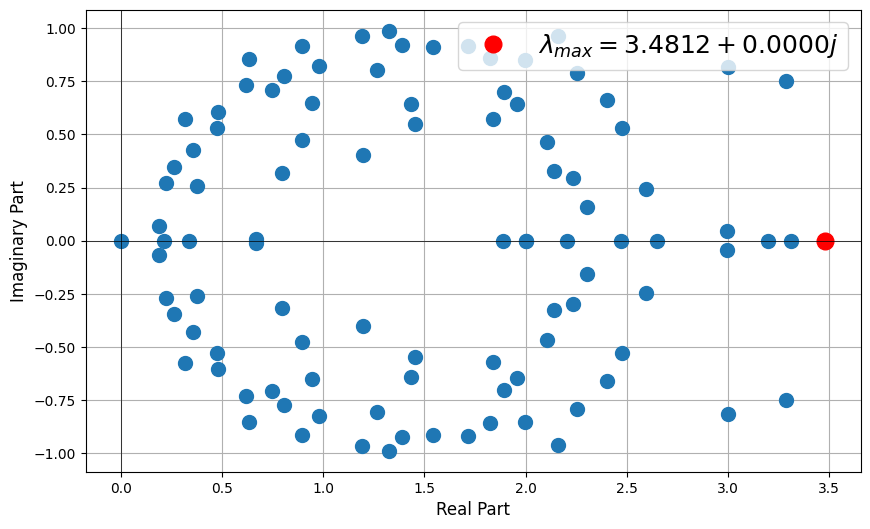

lambda max: 3.481243408368847


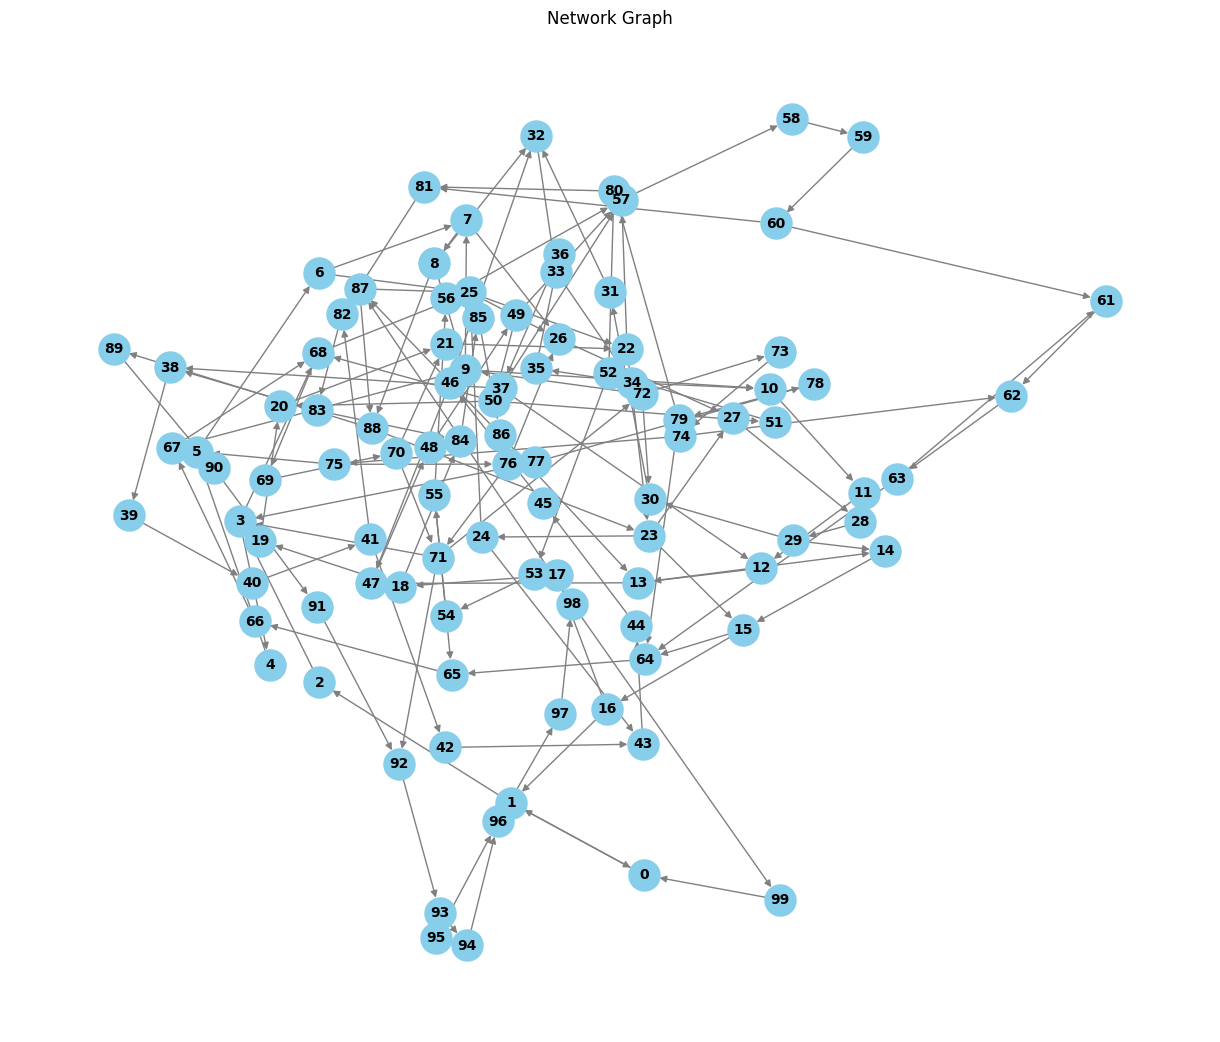

In [3]:
N = 100 # Number of agents
np.random.seed(1)
#np.random.seed(1896877)
A = create_strongly_connected_directed_graph(N, extra_edges=50) # Adj matrix
D = np.diag(np.sum(A, axis=1))  # Degree matrix
L = D - A # Laplatian Matrix
sigma_L = np.linalg.eigvals(L)
plot_eigenvalues(sigma_L)
lambda_max = np.abs(np.max(sigma_L))
'''
print('spectrum of L:')
for i in sigma_L:
    print(i)
'''
print(f'lambda max: {lambda_max}')
plot_network(A, node_size=500)

# Simulations

Standard Protocol

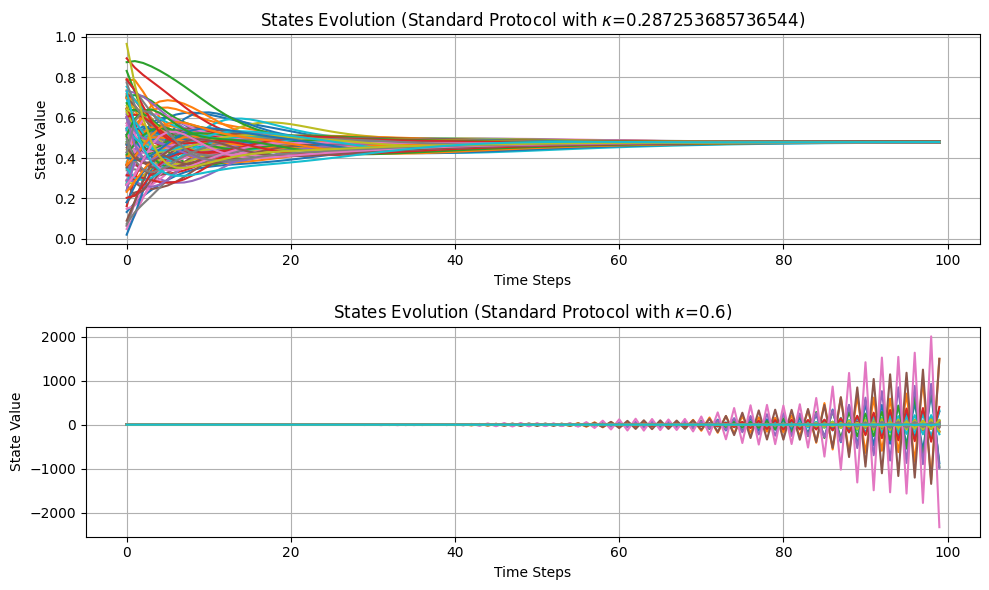

In [7]:
# Calculate lambda_max (maximum eigenvalue of L)

kappa_standard_1 =  (1 / lambda_max)
kappa_standard_2 = 0.6#0.2+(1 / lambda_max)
g_standard = 1  # Parameter g for standard protocol (1 such that it is ininfluent)
T=100
# Simulate using the standard protocol
x_final_standard_1, x_trajectory_standard_1 = simulate_network(
    N,\
    T,\
    'standard',\
    L,\
    A,\
    kappa_standard_1,\
    g_standard
)
x_final_standard_2, x_trajectory_standard_2 = simulate_network(
    N,\
    T,\
    'standard',\
    L,\
    A,\
    kappa_standard_2,\
    g_standard
)
# Plot the convergence for the centralized protocol
#plot_convergence(x_trajectory_standard, 'Standard')
trajectories = [
    x_trajectory_standard_1,\
    x_trajectory_standard_2
]
params = [kappa_standard_1,kappa_standard_2]
plot_comparison(trajectories, 'Standard', '$\kappa$',params)

# Print final states
#print("Final states (Standard):", x_final_standard_1)
#print("Final states (Standard):", x_final_standard_2)

Centralized Protocol

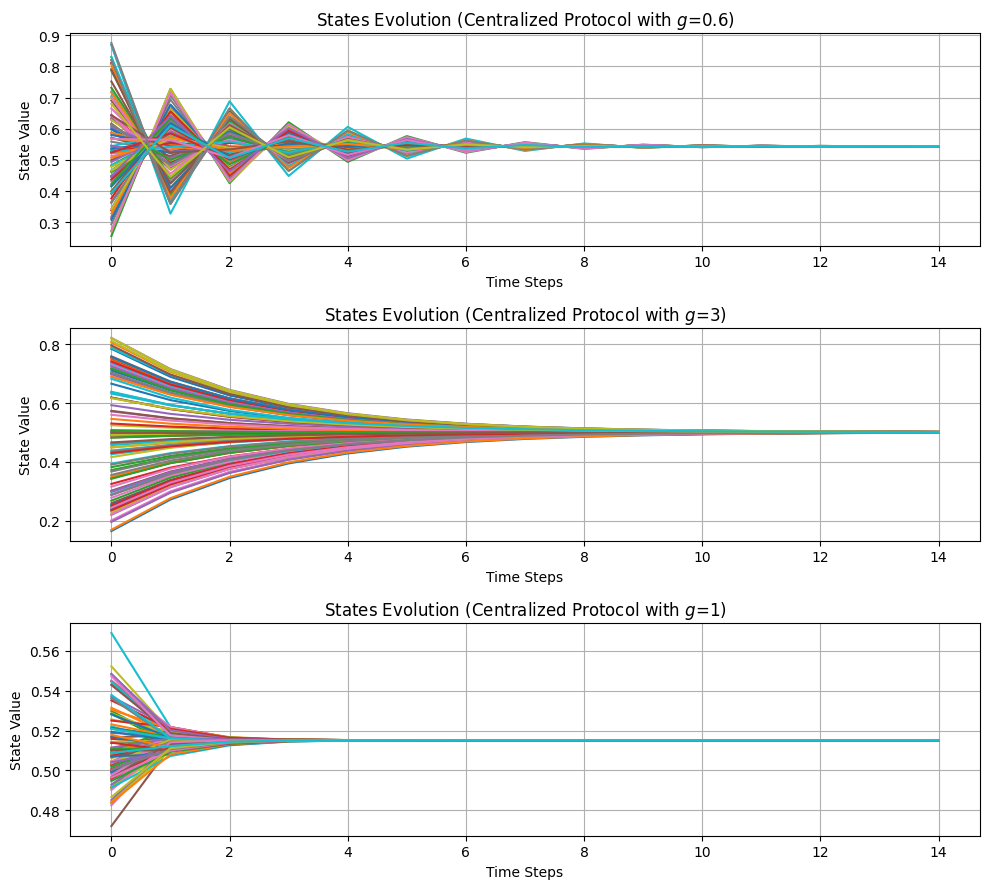

In [8]:
# Calculate lambda_max (maximum eigenvalue of L)
kappa_centralized =  20 # can be big as we want
g_1 = 0.6  # Parameter g for centralized protocol (1 such that it is ininfluent)
g_2 = 3
g_3 = 1
# Simulate using the centralized protocol
x_final_centralized_1, x_trajectory_centralized_1 = simulate_network(
    N,\
    15,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_1
)
x_final_centralized_2, x_trajectory_centralized_2 = simulate_network(
    N,\
    15,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_2
)
x_final_centralized_3, x_trajectory_centralized_3 = simulate_network(
    N,\
    15,\
    'centralized',\
    L,\
    A,\
    kappa_centralized,\
    g_3
)
trajectories = [
    x_trajectory_centralized_1,\
    x_trajectory_centralized_2,\
    x_trajectory_centralized_3
]
params = [g_1,g_2,g_3]
# Plot the convergence for the centralized protocol
#plot_convergence(x_trajectory_centralized, 'Centralized')
plot_comparison(trajectories, 'Centralized', '$g$',params)

# Print final states
#print("Final states (Centralized):", x_final_centralized_1)
#print("Final states (Centralized):", x_final_centralized_2)
#print("Final states (Centralized):", x_final_centralized_3)

Distributed Protocol

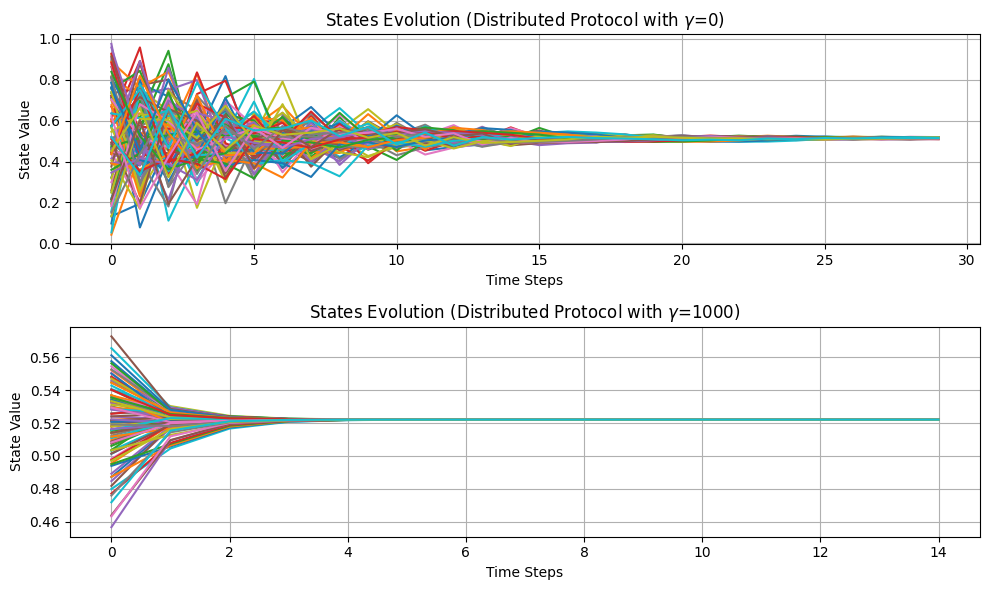

In [9]:
kappa = 20  # Coupling strength for distributed protocol
g_distributed = 1  # Parameter g for distributed protocol (should be >= 0.5)
gamma_1 = 0  # Number of iterations for distributed protocol
gamma_2=1000
# Simulate using the distributed protocol
x_final_distributed_1, x_trajectory_distributed_1 = simulate_network(
    N,\
    30,\
    'distributed',\
    L,\
    A,\
    kappa,\
    g_distributed,\
    gamma_1
)
x_final_distributed_2, x_trajectory_distributed_2 = simulate_network(
    N,\
    15,\
    'distributed',\
    L,\
    A,\
    kappa,\
    g_distributed,\
    gamma_2
)
trajectories = [x_trajectory_distributed_1,x_trajectory_distributed_2]
params = [gamma_1, gamma_2]
# Plot the convergence for the distributed protocol
plot_comparison(trajectories, 'Distributed', '$\gamma$',params)
#print("Final states (Distributed):", x_final_distributed_1)
#print("Final states (Distributed):", x_final_distributed_2)